In [132]:
import pandas as pd
from Functions import Metrics
from sklearn.metrics import accuracy_score, roc_auc_score
import math

In [133]:
df = pd.read_csv('train_clean.csv')
df.head(3)

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,geo_cod
0,0,15674932,Okwudilichukwu,668,France,1,33.0,3,0.0,2,1.0,0.0,181449.97,0,0
1,1,15749177,Okwudiliolisa,627,France,1,33.0,1,0.0,2,1.0,1.0,49503.50,0,0
2,2,15694510,Hsueh,678,France,1,40.0,10,0.0,2,1.0,0.0,184866.69,0,0


## Modelado

### Feature Engineering

In [134]:
#NUMERO DE OBSERVACIONES QUE SE FUEROND EL BANCO
n_exited = df.loc[df.Exited == 1].shape[0]

#DATAFRAME COMPLEMENTARIO CON MUESTRAS DE AQUELLAS QUE NO
df_sample = df.loc[df.Exited == 0].sample(n=n_exited*2, random_state=5)

#UNION DE REGISTROS
df_sample = pd.concat([df_sample,
                       df.loc[df.Exited == 1]],
                       axis=0)

df_sample = df_sample.reset_index(drop=True)
print(f'Filas y columnas: {df_sample.shape}')


Filas y columnas: (104763, 15)


In [135]:
dummies = pd.get_dummies(df_sample['Geography'], dtype=int)
dummies.head()

,France,Germany,Spain
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0


In [136]:
#NORMALIZACION
from sklearn.preprocessing import StandardScaler

#LISTA DE VARIABLES A NORMALIZAR
vars = ['Age','Balance']#'CreditScore',

#INSTANCIA DEL MODELO Y TRANSOFRMACION
std_vars = StandardScaler().fit_transform(df_sample[vars])

#SE CREA DATAFRAME COMPLEMETARIO
std_vars = pd.DataFrame(std_vars, columns=vars)
std_vars.head(3)

,Age,Balance
0,-0.221199,1.400622
1,0.325969,-0.916580
2,-0.111766,-0.916580


In [137]:
#SELECCION DE VARIABLES
vars = ['NumOfProducts','IsActiveMember','Gender']

#VARIABLES PREDICTIVAS
x = pd.concat([df_sample[vars],
                std_vars,
                dummies], axis=1)

#VARIABLE OBJETIVO
y = df_sample.Exited

In [138]:
#IMPORTACION DE LIBRERIA
from sklearn.model_selection import train_test_split

#DIVISION DE DATOS PARA TRAIN Y TEST
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, stratify=y,random_state=42)

### KNN - Entrenamiento y validacion simple del modelo

In [139]:
from sklearn.neighbors import KNeighborsClassifier


#INSTANCIA Y ENTRENAMIENTO DEL MODELO
model = KNeighborsClassifier(n_neighbors=35)
model.fit(X_train, y_train)

#PREDICCION
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_true=y_test ,y_pred=y_pred)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.8243


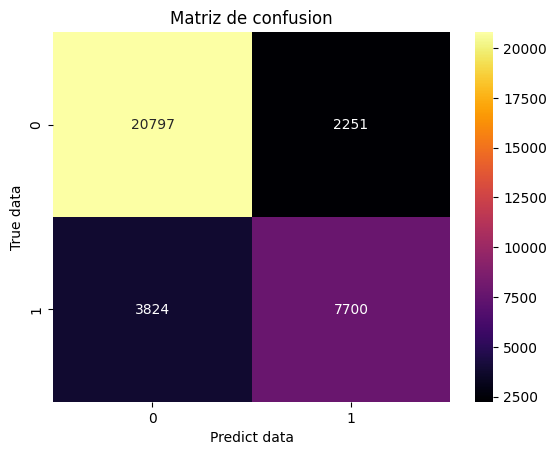

In [140]:
#GRAFICO MATRIZ DE CONFUSION
Metrics().plot_confusion_matrix_dicotomic(y_test, y_pred, None, None)

In [141]:
#REPORTE
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.90      0.87     23048
           1       0.77      0.67      0.72     11524

    accuracy                           0.82     34572
   macro avg       0.81      0.79      0.79     34572
weighted avg       0.82      0.82      0.82     34572



In [142]:
#SCORE CURVA ROC
y_prob = model.predict_proba(X_test)[:,1]
print(f'Score curva ROC: {roc_auc_score(y_test, y_prob):.4f}')

Score curva ROC: 0.8826


### Random Forest - Entrenamiento y validacion simple del modelo

In [143]:
#IMPOTRACION DE MODELO PARA TEST DE PARAMETROS
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

grid_param = param_grid = {
    'criterion' : ['entropy'],
    'n_estimators': [200, 300],
    'max_depth': [10, 18, 20],
    #'max_features' : [0.5],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4],
    'bootstrap': [True, False],
    'random_state': [42]
}

#SE ENTRENA MODELO UTILIZANDO GRIDSEARCH
model = GridSearchCV(estimator=RandomForestClassifier(),
                     param_grid=param_grid,
                     cv=3, n_jobs=-1,
                     scoring='accuracy')

model.fit(X_train, y_train)

model.best_score_

In [144]:
from sklearn.ensemble import RandomForestClassifier

#INSTANCIA Y ENTRENAMIENTO DEL MODELO
model = RandomForestClassifier( bootstrap=True,
                                criterion='entropy',
                                max_depth=10,
                                min_samples_leaf=4,
                                min_samples_split=5,
                                n_estimators=200,
                                random_state=42)
model.fit(X_train, y_train)

#PREDICCION
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_true=y_test ,y_pred=y_pred)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.8251


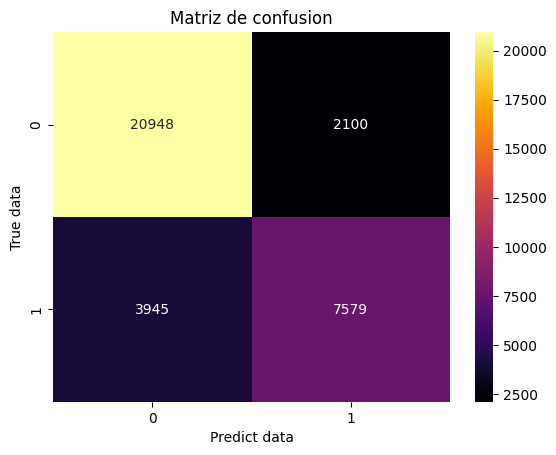

In [145]:
#GRAFICO DE MATRIZ DE CONFUSION
Metrics().plot_confusion_matrix_dicotomic(y_test, y_pred, None, None)

In [38]:
#REPORTE
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.91      0.87     23048
           1       0.78      0.65      0.71     11524

    accuracy                           0.82     34572
   macro avg       0.81      0.78      0.79     34572
weighted avg       0.82      0.82      0.82     34572



In [39]:
#SCORE CURVA ROC
y_prob = model.predict_proba(X_test)[:,1]
print(f'Score curva ROC: {roc_auc_score(y_test, y_prob):.4f}')

Score curva ROC: 0.8866


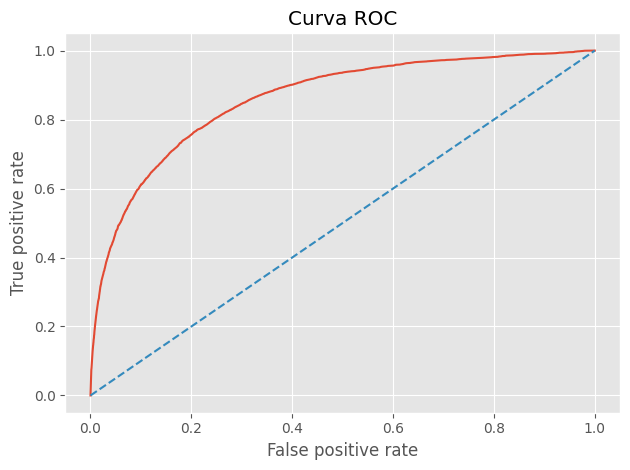

In [14]:
#PLOT CURVE ROC
Metrics().plot_roc_curve(y_test, y_prob)

### XG-Boost - Entrenamiento y validacion simple del modelo

In [146]:
#IMPOTRACION DE MODELO PARA TEST DE PARAMETROS
from sklearn.model_selection import GridSearchCV

#GRILLA DE PARAMETROS PARA TESTEAR
param_grid = {
    'objective' :['binary:logistic'],
    'max_depth': [10, 15],
    'learning_rate': [0.1, 0.2],
    'n_estimators': [9, 15],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9],
    'gamma': [0.1, 0.2],
    'random_state': [47]
}

In [147]:
#IMPORTACION MODELO DE BOOOSTING
from xgboost import XGBClassifier

#SE ENTRENA MODELO UTILIZANDO GRIDSEARCH
#model = GridSearchCV(estimator=XGBClassifier(),
#                     param_grid=param_grid,
#                     cv=3, n_jobs=-1,
#                     scoring='accuracy')


model = XGBClassifier( objective = 'binary:logistic',
                       max_depth = 10,
                       learning_rate = 0.2,
                       n_estimators = 15,
                       subsample = 0.9,
                       colsample_bytree = 0.8,
                       gamma = 0.2,
                       random_state = 47)

#ENTRENAMIENTO
model.fit(X_train,y_train)

#PREDICCION
y_pred = model.predict(X_test)

#SCORE
accuracy_score(y_true=y_test, y_pred=y_pred)

0.8258706467661692

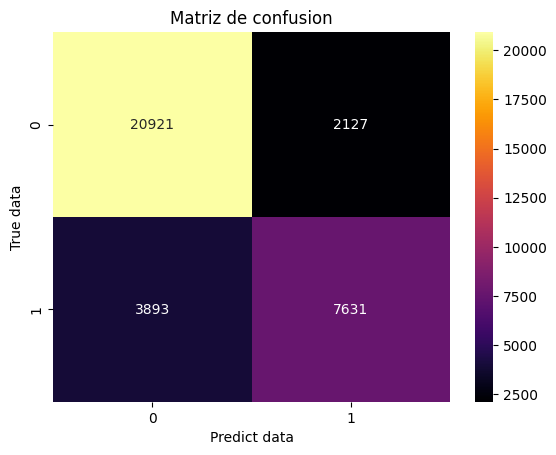

In [148]:
Metrics().plot_confusion_matrix_dicotomic(y_test, y_pred, None, None)

In [46]:
#SCORE CURVA ROC
y_prob = model.predict_proba(X_test)[:,1]
print(f'Score curva ROC: {roc_auc_score(y_test, y_prob):.4f}')

Score curva ROC: 0.8859


In [47]:
#REPORTE
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.91      0.87     23048
           1       0.78      0.65      0.71     11524

    accuracy                           0.82     34572
   macro avg       0.81      0.78      0.79     34572
weighted avg       0.82      0.82      0.82     34572



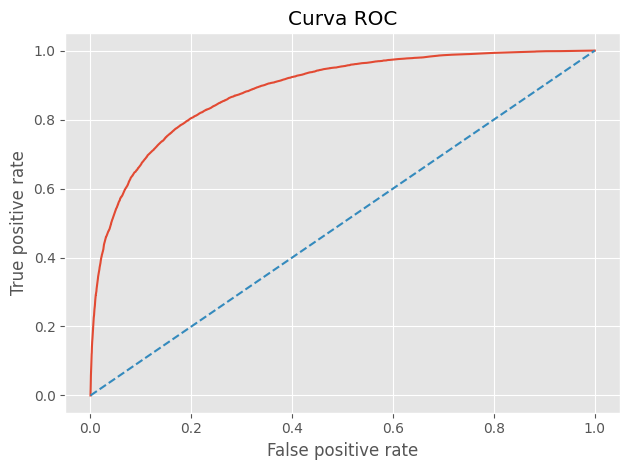

In [45]:
#PLOT CURVE ROC
Metrics().plot_roc_curve(y_test, y_prob)

model = GridSearchCV(DecisionTreeClassifier(),
                     param_grid=param_grid,
                     cv=3,
                     n_jobs=-1,
                     scoring='accuracy')

model.fit(X_train, y_train)

print(f'Mejor puntaje de validacion cruzada(en entrenamiento): {model.best_score_}')
print('\nMejores parametros:')
for key, value in model.best_params_.items():
    print(f'\t{key}: {value}')

### Prediccion

In [21]:
df_test = pd.read_csv('test.csv')

In [22]:
#TRANSFORMACION VARIABLE GENDER
df_test.loc[df_test.Gender == 'Female', 'Gender'] = '0'
df_test.loc[df_test.Gender == 'Male', 'Gender'] = '1'
df_test.Gender = df_test.Gender.astype(int)
df_test.Gender.value_counts()

#TRANSFORMACION DE VARIABLES CATEGORICAS
dummies = pd.get_dummies(df_test['Geography'], dtype=int)
dummies.head()

#LISTA DE VARIABLES A NORMALIZAR
vars = ['Age','Balance']

#INSTANCIA DEL MODELO Y TRANSOFRMACION
std_vars = StandardScaler().fit_transform(df_test[vars])

#SE CREA DATAFRAME COMPLEMETARIO
std_vars = pd.DataFrame(std_vars, columns=vars)

#SELECCION DE VARIABLES
vars = ['NumOfProducts','IsActiveMember','Gender']

#VARIABLES PREDICTIVAS
x = pd.concat([df_test[vars],
                std_vars,
                dummies], axis=1)

#PREDICCION
y_pred = model.predict(x)

In [23]:
#CONCATENACION DE ARCHIVO PARA EXPORTAR
y_pred = pd.Series(y_pred, name='Exited')
sample_submission = pd.concat([df_test.id, y_pred], axis=1)

In [24]:
#sample_submission.to_csv('submission.csv', index=False)

In [25]:
sample_submission.head()

,id,Exited
0,165034,0
1,165035,1
2,165036,0
3,165037,0
4,165038,1
